# La influencia sectorial de migrantes

> La migración interna tiene efectos diferentes sobre la productividad e innovación de distintos sectores en la economía boliviana.

Existe evidencia de que la migración puede tener un efecto positivo sobre la productividad e innovación en economías de destino. Migrantes poseen conocimientos con un fuerte potencial productivo, redes que pueden mejorar la eficiencia de cadenas de suministro, y la capacidad y motivación de combinar estos recursos en formas novedosas para crear bienes y servicios de valor. Este efecto debería depender de las características productivas de la migración y las dinámicas de crecimiento en sectores económicos, determinadas por la tecnología. Existe poca evidencia de la heterogeneidad en este efecto, particularmente para casos poco documentados como la migración interna en Bolivia. En este trabajo, utilizo datos del destino de créditos a unidades económicas para estimar una medida del efecto relativo de la migración interna sobre la productividad e innovación entre sectores económicos. 

Entidades financieras otorgan crédito a empresas de las que esperan crecimiento, y empresas acuden a ellas cuando sus proyecciones no pueden ser satisfechas con alternativas informales de crédito, cuando son capaces de argumentar bien estas proyecciones y cumplir requisitos de formalización. El financiamiento de nuevas actividades en un municipio podría indicar que nadie las producía antes o que, si lo hacía, sus expectativas de crecimiento eran demasiado pequeñas. Es decir que nuevas actividades en la cartera de créditos de un municipio serían indicativas de eventos de innovación o saltos en productividad. En este trabajo, identifico 11614 eventos donde aparecen nuevas actividades en municipios. Mido cuán frecuentemente estas mismas actividades estaban presentes durante el periodo anterior en los municipios que envían más migrantes y corrijo el efecto de la ubicuidad de actividades en el país. Finalmente agrego estos datos por actividad y sector económico, y los comparo con resultados de la influencia relativa de municipios vecinos. Sugiero que esta medida puede ser utilizada para identificar actividades y sectores económicos donde migrantes internos tienen una mayor influencia productiva, y que su promoción en políticas de desarrollo podría no sólo beneficiar más a poblaciones migrantes, sino tener un impacto geográfico más amplio, aprovechando su mayor potencial de difusión.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
from IPython import display
import numpy as np
import geopandas as gpd
import itertools
import textwrap
import seaborn as sns
import matplotlib.patheffects as pe

plt.style.use('publish/estilo.mplstyle')
pd.options.display.max_rows=50
pd.options.display.max_colwidth=300

In [14]:
def load_mapa():
    """
    Lee datos de un mapa de los límites administrativos 
    de municipios en Bolivia que puede ser descargado en
    https://archive.org/download/asfi.Servicios_Financieros_ASFI31082019/asfi:Servicios_Financieros_ASFI31082019.geojson
    
    Retorna un geodataframe con los datos necesarios
    para operaciones posteriores.
    """
    
    
    gdf = gpd.read_file('data/asfi Servicios_Financieros_ASFI31082019.geojson')
    gdf = gdf[gdf.COD_INE.notna()]
    gdf['cod_ine'] = gdf.COD_INE.astype(int)
    gdf = gdf[['cod_ine', 'DEPARTAMEN', 'MUNICIPIO', 'geometry']]
    gdf.columns = ['cod_ine', 'departamento', 'municipio', 'geometry']
    return gdf

def get_vecinos(mapa):
    """
    Consume el mapa de municipios de Bolivia y 
    retorna un diccionario donde cada llave es el 
    código INE de un municipio y su contenido 
    una lista con el código de cada municipio vecino.
    """
    
    vecinos = {}
    for index, row in mapa.iterrows():
        neighbors = mapa[mapa.geometry.touches(row['geometry'])].cod_ine.tolist() 
        vecinos[row.cod_ine] = neighbors
    return vecinos

def get_inventario_actividades(creditos):
    """
    Construye un diccionario de cada actividad en 
    cada año para cada municipio presente en la 
    base de datos de créditos.
    """
    
    actividades = {}
    for i, a in creditos[creditos.cartera > 0].groupby(['cod_ine', 'year']).subclase:
        if i[0] not in actividades.keys():
            actividades[i[0]] = {}
        actividades[i[0]][i[1]] = a.tolist()
    return actividades
    
def get_eventos(actividades_dict):
    """
    Identifica eventos donde una actividad aparece 
    por primera vez en un municipio. Retorna un diccionario 
    de estos eventos agrupados por año y municipio.
    """
    
    innovaciones = {}
    for mun in actividades_dict.keys():
        innovaciones[mun] = {}
        for year in range(2012,2020):
            if not actividades_dict[mun].__contains__(year):
                base_year = []
            else:
                prev = set([])
                [prev.update(set(actividades_dict[mun][y])) for y in actividades_dict[mun].keys() if y < year + 1]
                prev = list(prev)
            if not actividades_dict[mun].__contains__(year + 1):
                change_year = []
            else:
                change_year = actividades_dict[mun][year + 1]

            innovaciones[mun][year + 1] = list(set(change_year).difference(set(prev)))
            
    return innovaciones

def influencia_simple(innovaciones, vecinos, creditos, actividades):
    """
    Para cada evento, calcula el número de vecinos 
    que producían la misma actividad el año anterior.
    Devuelve un dataframe con información de cada evento.
    """
    
    municipios_cartera = creditos[creditos.cartera > 0].cod_ine.unique().tolist()
    influencia = []
    for mun in innovaciones.keys():
        vv = set(vecinos[mun]).intersection(set(municipios_cartera))
        if len(vv) == 0:
            for year in innovaciones[mun]:
                for actividad in innovaciones[mun][year]:
                    influencia.append({'cod_ine': mun, 'year': year, 'actividad': actividad, 'presente_vecinos': np.nan, 'presente': 0, 'vecinos': 0})
        else:
            for year in innovaciones[mun]:
                for actividad in innovaciones[mun][year]:
                    presente = 0
                    total = len(vv)
                    for v in vv:
                        if actividades[v].__contains__(year - 1):
                            if actividad in actividades[v][year - 1]:
                                presente += 1
                    influencia.append({'cod_ine': mun, 'year': year, 'actividad': actividad, 'presente_vecinos': presente/total, 'presente': presente, 'vecinos': total})
    df = pd.DataFrame(influencia)
    df['categoria'] = df.actividad.map(creditos.groupby('subclase').categoria.first().to_dict())
    return df

def influencia_por_actividad(eventos, start):
    """
    Agrupa eventos por actividad desde un año, devuelve 
    un dataframe con la media del porcentaje de vecinos 
    ue producían la actividad un año antes del evento.
    """
    
    df = eventos[eventos.year >= start]
    resumen = pd.concat(
        [
            df.groupby("actividad")[["categoria"]].first(),
            df.groupby("actividad").cod_ine.count(),
            df.groupby("actividad").presente_vecinos.mean(),
            pd.Series({i: len(dfi) for i, dfi in creditos[(creditos.cartera > 0) & (creditos.year == start)].groupby('subclase').cod_ine.unique().iteritems()}).sort_values()
        ],
        axis=1
    ).dropna()
    resumen.columns = ['categoria', 'eventos', 'influencia_simple', 'ubicuidad']
    resumen[['eventos', 'ubicuidad']] = resumen[['eventos', 'ubicuidad']].astype(int)
    resumen['influencia_ponderada'] = resumen.influencia_simple * (np.log(179 / resumen.ubicuidad))
    return resumen.sort_values('influencia_ponderada', ascending=False)

def influencia_por_categoria(influencia, min_eventos, min_actividades):
    """
    Agrupa eventos por categoría, devuelve un dataframe con
    la media y distribución estándar del porcentaje de 
    vecinos para cada actividad con al menos un número
    mínimo de eventos.
    """
    
    df = influencia[influencia.eventos >= min_eventos]
    resumen = pd.concat(
        [
            df.groupby("categoria").influencia_ponderada.mean(),
            df.groupby("categoria").influencia_ponderada.std(),
            df.groupby("categoria").eventos.count(),
        ],
        axis=1,
    )
    resumen.columns = ['influencia_ponderada', 'desviación', 'actividades']
    resumen = resumen[resumen.actividades >= min_actividades]
    return resumen[['actividades', 'influencia_ponderada', 'desviación']].sort_values('influencia_ponderada', ascending=False)

def make_migration_matrix():
    """
    Lee la matriz de flujos migratorios intermunicipales
    entre 2007 y 2012, del Censo 2012.
    """
    
    df = pd.read_csv('data/migracion_2012.csv', index_col=[0])
    municipios = pd.read_csv('data/cod_ine_censo2012.csv', names=['cod_ine', 'municipio'])
    df.index = municipios.cod_ine
    df.columns = municipios.cod_ine
    for col in df.columns:
        df[col] = pd.to_numeric(df[col].apply(lambda x: x.replace(' ', '').replace('-', ''))).fillna(0).astype(int)
    return df

def fuentes_migracion(migracion, top=10):
    """
    Devuelve una lista con un máximo de `top` municipios que envían más
    migrantes a cada municipio.
    """
    
    return {cod_ine: row[row > 0].sort_values().head(top).index.tolist() for cod_ine, row in migracion.iterrows()}

def plot_difusion(actividad, mapa, ax, since=2016):

    ax.set_axis_off()
    
    dfi = eventos[(eventos.actividad == actividad) & (eventos.year >= since)]
    mapa.plot(ax=ax, color='#e3e4e8', linewidth=.5, edgecolor='#f9f9f9')
    mapa[mapa.cod_ine.isin(creditos[(creditos.year > since) & (creditos.subclase == actividad) & (creditos.cartera > 0)].cod_ine.unique())].plot(ax=ax, color='#ced4eb', linewidth=.5, edgecolor='#f9f9f9')
    
    colormap = colors.ListedColormap(cm.get_cmap('magma')(np.linspace(.2,.8,250)))
    colores = {year: colors.to_hex(colormap((year-since)/(2021-since))) for year in range(since, 2021)}
    for year, dfyear in dfi.groupby('year'):
        mapa[mapa.cod_ine.isin(dfyear.cod_ine)].plot(ax=ax, color=colores[year], linewidth=.5, edgecolor='#f7f7f7')

Primero identifico eventos donde actividades económicas son registradas por primera vez en un municipio. Para eso, construyo un inventario de actividades presentes en cada municipio y año, y examino si cada una estaba presente en años previos. Entre estos eventos, existen actividades que aparecen y desaparecen entre periodos, y no son representativas del fenómeno que quiero medir. Para filtrarlas, sólo considero eventos desde 2016, convirtiendo al periodo entre 2012 y 2015 en la línea base. Es decir que para clasificar un evento como una innovación o un salto en productividad no debe haber estado presente en la cartera de créditos de un municipio por al menos 3 años.

In [4]:
creditos = pd.read_csv('data/creditos.csv')
inventario_actividades = get_inventario_actividades(creditos)
eventos = get_eventos(inventario_actividades)

Con esta lista, para cada municipio, actividad y año en un evento, mido en qué porcentaje de los municipios que envían más migrantes estaba presente la misma actividad un año antes. Primero, selecciono el grupo de 10 municipios que enviaron más migrantes y están presentes en la base de datos de créditos. Luego, examino qué porcentaje de municipios en este grupo producía la misma actividad el año anterior. Finalmente, calculo la media del porcentaje de eventos para cada actividad económica con al menos 10 eventos. El propósito de este límite es ganar poder estadístico.

Un problema importante con esta medida es que refleja demasiado la distribución de la ubicuidad de actividades económicas. En otras palabras, las actividades que estaban más presentes en municipios con mayor flujo inmigratorio son también las actividades que estaban más presentes en general. Para controlar este efecto, multiplico esta medida por un factor de ponderación que consiste en el logaritmo de la división del número total de municipios entre el número de municipios donde la actividad estaba presente. A diferencia de la anterior medida, esta nueva medida ponderada no refleja las actividades más comunes sino actividades donde el efecto de la migración interna es alto mientras que su ubicuidad se mantiene baja. Es decir, actividades donde la migración probablemente tiene un efecto mayor. Produzco esta medida ponderada para cada actividad económica con al menos 10 eventos utilizando la ubicuidad de cada actividad en 2016, el primer año del que considero eventos. Finalmente calculo la media simple de esta medida en actividades para cada sector económico. 

In [15]:
migracion = make_migration_matrix()
fuentes = fuentes_migracion(migracion, 10)
eventos_migracion = influencia_simple(eventos, fuentes, creditos, inventario_actividades)
actividades_migracion = influencia_por_actividad(eventos_migracion, start=2016)
categorias_migracion = influencia_por_categoria(actividades_migracion, 10, 2)

Una muestra aleatoria de 10 eventos desde 2016:

In [23]:
eventos_migracion[eventos_migracion.year > 2015].sample(10)[['year', 'cod_ine', 'categoria', 'actividad']]

,year,cod_ine,categoria,actividad
706,2017,10801,venta al por mayor y menor,venta de vehiculos automotores nuevos
9534,2019,71003,construccion,pintura y trabajos de decoracion
9847,2016,71103,industria manufacturera,elaboracion de aceites y grasas vegetales refinadas y subproductos
3209,2019,30101,industria manufacturera,fabricacion de productos de hornos de coque
6076,2020,40201,hoteles y restaurantes,servicio de expendio de jugos zumos y ensaladas de frutas
58,2018,10101,agricultura y ganaderia,produccion de lana fibra pelo de animales (esquila)
7357,2016,60303,hoteles y restaurantes,servicios de alojamiento en hoteles
5407,2018,31206,construccion,instalaciones y mantenimiento electrico y electronicos
2243,2019,21104,venta al por mayor y menor,venta al por menor de animales domesticos
2820,2019,21401,transporte almacenamiento y comunicaciones,otros servicios de transporte no regular de pasajeros


Las 30 actividades con al menos 10 eventos donde la migración tiene una mayor influencia relativa:

In [30]:
actividades_migracion[actividades_migracion.eventos > 10].sort_values('influencia_ponderada', ascending=False).head(30)

,categoria,eventos,influencia_simple,ubicuidad,influencia_ponderada
venta al por menor de productos textiles excepto prendas de vestir,venta al por mayor y menor,14,0.477098,64,0.490696
cultivo de hortalizas de hoja,agricultura y ganaderia,16,0.319568,39,0.486966
apicultura,agricultura y ganaderia,24,0.300281,36,0.481611
fabricacion de muebles y partes de muebles principalmente de metal,industria manufacturera,14,0.465788,64,0.479064
preparacion de tortas y produccion de harinas y productos residuales de la produccion de aceite,industria manufacturera,14,0.441695,62,0.468308
reparacion de articulos electricos de uso domestico,venta al por mayor y menor,11,0.344949,47,0.461280
venta al por menor de muebles articulos de mimbre y corcho; colchones y somiers,venta al por mayor y menor,15,0.535661,76,0.458876
fabricacion de productos metalicos ncp,industria manufacturera,12,0.485086,70,0.455443
cultivo de flores y plantas ornamentales,agricultura y ganaderia,19,0.357686,51,0.449096
cultivo de especias y de plantas aromaticas y medicinales,agricultura y ganaderia,14,0.260119,32,0.447834


La influencia relativa de la migración entre sectores económicos:

In [26]:
categorias_migracion

,actividades,influencia_ponderada,desviación
categoria,,,
agricultura y ganaderia,29,0.334739,0.081332
venta al por mayor y menor,79,0.330996,0.091336
servicios inmobiliarios empresariales y de alquiler,17,0.322292,0.122605
hoteles y restaurantes,19,0.313206,0.079087
transporte almacenamiento y comunicaciones,12,0.293043,0.086475
minerales metalicos y no metalicos,3,0.290764,0.167831
industria manufacturera,63,0.285644,0.100057
construccion,12,0.250156,0.110060
servicios sociales comunales y personales,18,0.231468,0.110499


¿Cómo se compara esta influencia con la de factores de producción geográficamente localizados y no relacionados al fenómeno migratorio? Repito este ejercicio reemplazando el grupo de municipios que envían más migrantes con los municipios que comparten una frontera administrativa y están presentes en la base de datos de créditos.

In [17]:
mapa = load_mapa()
vecinos = get_vecinos(mapa)
eventos_frontera = influencia_simple(eventos, vecinos, creditos, inventario_actividades)
actividades_frontera = influencia_por_actividad(eventos_frontera, start=2016)
categorias_frontera = influencia_por_categoria(actividades_frontera, 10, 2)

Las 30 actividades con al menos 10 eventos donde municipios vecinos tienen más influencia relativa:

In [31]:
actividades_frontera[actividades_frontera.eventos >= 10].sort_values('influencia_ponderada', ascending=False).head(30)

,categoria,eventos,influencia_simple,ubicuidad,influencia_ponderada
servicio de atencion medica en clinicas,servicios sociales comunales y personales,11,0.318290,23,0.653097
cria de ganado camelido,agricultura y ganaderia,15,0.292222,23,0.599608
matanza de ganado excepto el bovino y procesamiento de su carne,industria manufacturera,10,0.256905,19,0.576224
cultivos de plantas para bebidas y estimulantes,agricultura y ganaderia,13,0.351918,36,0.564430
elaboracion de productos de confiteria,industria manufacturera,14,0.349634,36,0.560766
otros servicios de credito,intermediacion financiera,42,0.232183,16,0.560674
venta al por menor en supermercados con surtido compuesto y predominio de productos alimenticios bebidas y tabaco,venta al por mayor y menor,11,0.511905,60,0.559533
fabricacion de cuerdas cordeles bramantes y redes,industria manufacturera,13,0.238095,18,0.546908
venta al por mayor de productos quimicos,venta al por mayor y menor,10,0.293571,29,0.534326
fabricacion de chompas y articulos similares de punto,industria manufacturera,17,0.348958,40,0.522916


La influencia relativa de municipios vecinos sobre sectores económicos:

In [32]:
categorias_frontera

,actividades,influencia_ponderada,desviación
categoria,,,
minerales metalicos y no metalicos,3,0.342794,0.018870
industria manufacturera,63,0.342433,0.110154
agricultura y ganaderia,29,0.341262,0.100433
servicios sociales comunales y personales,18,0.316411,0.115797
servicios inmobiliarios empresariales y de alquiler,17,0.315180,0.080783
hoteles y restaurantes,19,0.313758,0.090275
venta al por mayor y menor,79,0.296945,0.091326
transporte almacenamiento y comunicaciones,12,0.293264,0.109202
construccion,12,0.264601,0.085258


Finalmente, una comparación visual entre el efecto de la migración y vecindad sobre cada actividad y sector económico. El tamaño de cada punto refleja el número de eventos y actividades por actividad y sector respectivamente.

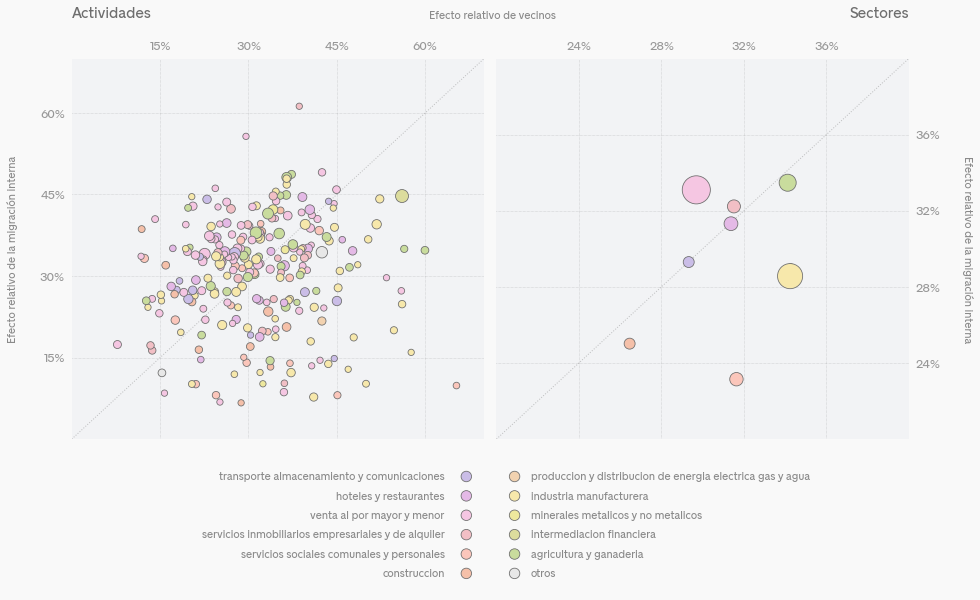

In [33]:
def plot_efecto(actividades_frontera, actividades_migracion, categorias_frontera, categorias_migracion):
    colores_categorias = {
        'venta al por mayor y menor': '#f5c6e2',
        'industria manufacturera': '#f7e8ab',
        'construccion': '#f5c0a9',
        'servicios inmobiliarios empresariales y de alquiler': '#f2bfc5',
        'transporte almacenamiento y comunicaciones': '#cabde7',
        'agricultura y ganaderia': '#c9dc9d',
        'hoteles y restaurantes': '#e4b9e6',
        'servicios sociales comunales y personales': '#fbc6bb',
        'produccion y distribucion de energia electrica gas y agua': '#f2d2b0',
        'intermediacion financiera': '#dcdc9d',
        'minerales metalicos y no metalicos': '#eee89d',
        'caza silvicultura y pesca': '#e7e7e7',
        'educacion': '#e7e7e7',
        'servicio de hogares privados que contratan servicio domestico': '#e7e7e7',
        'actividades atipicas': '#e7e7e7',
        'administracion publica defensa y seguridad social obligatoria': '#e7e7e7',
        'extraccion de petroleo crudo y gas natural': '#e7e7e7',
        'servicio de organizaciones y organos extraterritoriales': '#e7e7e7',
        'otros': '#e7e7e7',
    }
    categorias_orden = [
        'transporte almacenamiento y comunicaciones',
        'hoteles y restaurantes',
        'venta al por mayor y menor',
        'servicios inmobiliarios empresariales y de alquiler',
        'servicios sociales comunales y personales',
        'construccion',
        'produccion y distribucion de energia electrica gas y agua',
        'industria manufacturera',
        'minerales metalicos y no metalicos',
        'intermediacion financiera',
        'agricultura y ganaderia',
        'otros'
    ]
    
    linecolor = '#6e6e6e'
    
    actividades_efecto = pd.concat([actividades_frontera[['categoria', 'eventos', 'influencia_ponderada']], actividades_migracion.influencia_ponderada], axis=1)
    actividades_efecto.columns = ['categoria', 'eventos', 'porcentaje_vecinos_territorio', 'porcentaje_vecinos_migracion']
    actividades_efecto['color'] = actividades_efecto.categoria.map(colores_categorias)
    actividades_efecto = actividades_efecto[actividades_efecto.eventos >= 10]
    
    categorias_efecto = pd.concat([categorias_frontera[['actividades', 'influencia_ponderada']], categorias_migracion['influencia_ponderada']], axis=1)
    categorias_efecto.columns = ['eventos', 'porcentaje_vecinos_territorio', 'porcentaje_vecinos_migracion']
    categorias_efecto['color'] = categorias_efecto.index.map(colores_categorias)

    f, axs = plt.subplots(1,2,figsize=(15,7))
    plt.subplots_adjust(wspace=.03)
    
    for ax, dfi, limits, scale, right_ticks in zip(axs, [actividades_efecto, categorias_efecto], [[.0, .7], [.2, .4]], [4, 10], [False, True]):
        ax.scatter(dfi.porcentaje_vecinos_territorio, dfi.porcentaje_vecinos_migracion, s=dfi.eventos * scale, c=dfi.color, linewidth=.8, edgecolor=linecolor, alpha=1., zorder=2)
        ax.grid()
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(ticker.PercentFormatter(1,0))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(6, prune='both'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(6, prune='both'))
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.tick_params(labelcolor=linecolor, labeltop=True, labelbottom=False)
        if right_ticks:
            ax.tick_params(labelleft=False, labelright=True)
        for label in list(itertools.chain.from_iterable([ax.get_xticklabels(), ax.get_yticklabels()])):
            label.set_alpha(.7)
        ax.plot(limits, limits, linewidth=1, color=linecolor, alpha=.4, linestyle=':', zorder=1)
    axs[0].annotate('Efecto relativo de vecinos', xy=(1.02,1.1), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='center', va='bottom')
    axs[0].annotate('Efecto relativo de la migración interna', xy=(-.13, .5), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='right', va='center', rotation=90)
    axs[1].annotate('Efecto relativo de la migración interna', xy=(1.13, .5), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='left', va='center', rotation=270)
    
    axs[0].annotate('Actividades', xy=(.0,1.1), xycoords='axes fraction', fontsize=15, alpha=1., color=linecolor, ha='left', va='bottom')
    axs[1].annotate('Sectores', xy=(1.,1.1), xycoords='axes fraction', fontsize=15, alpha=1., color=linecolor, ha='right', va='bottom')
            
    for categorias_section, esquina, x, ha, xlim  in zip([categorias_orden[:6], categorias_orden[6:]], [.457, .46], [.4, 1.6], ['right', 'left'], [(0,3), (-2,2)]):
        cax = f.add_axes([esquina, -.18, .1, .25])
        cax.scatter(x=len(categorias_section) * [1], y=range(len(categorias_section)),  color=[colores_categorias[categoria] for categoria in categorias_section], s=110, linewidth=.8, edgecolor=linecolor)
        cax.set_xlim(xlim)
        cax.set_ylim(6.,-.5)
        for categoria, position in zip(categorias_section, range(len(categorias_section))):
            cax.annotate('\n'.join(textwrap.wrap(categoria, 100)), xy=(x, position), xycoords='data', ha=ha, va='center', fontsize=11, color=linecolor, alpha=.8)
        cax.set_axis_off()

plot_efecto(actividades_frontera, actividades_migracion, categorias_frontera, categorias_migracion)

Si bien debería existir una correlación entre ambas influencias, desviaciones particulares en una u otra dirección son informativas sobre los mecanismos que pueden estar conduciendo al desarrollo de innovaciones e incrementos en productividad. Casos donde el efecto de la migración es mayor que el efecto de municipios vecinos, sugieren un rol predominante de factores de producción más móviles, como comercio, transporte o conocimiento. Mientras que casos donde el efecto de municipios vecinos es mayor apuntan a factores geográficamente localizados como infraestructura, calidad institucional, calidad de suelo y otros factores difíciles de trasladar con el movimiento de personas.

Por ejemplo, el efecto de la migración sobre los sectores más representativos: comercio, manufacturas y agricultura.

- **Comercio**. El efecto de la migración interna sobre actividades de comercio es alto y está particularmente dirigido por factores móviles. Abundan anécdotas sobre el protagonismo de migrantes internos en el comercio (Cielo & Durán, 2012; Medeiros et al., 2013; Tassi & Poma, 2020). El comercio es un buen encaje para migrantes porque puede representar una barrera de entrada baja, depende principalmente de factores móviles (capital, mercadería, transporte), y emplea efectivamente los recursos de redes de migrantes (préstamos de mercadería, disposición de puestos de venta, adquisición colectiva de mercadería y reducción de costos de transporte en viajes compartidos). 
- **Manufacturas**. El efecto de la migración interna sobre manufacturas es menor, más disperso y mucho más geográficamente localizado. Si bien existen actividades de manufactura bien difundidas por migrantes como la fabricación de partes metálicas o la confección de materiales textiles, en general la manufactura no es el mejor encaje para la migración interna. Algunas explicaciones son la mayor barrera de entrada (más requerimientos de capital), mayores costos de organización y tecnología, y la dependencia en una economía e infraestructura más desarrolladas (disposición de proveedores, maquinaria, empleados capacitados, servicios básicos, mayor seguridad y calidad institucional). 
- **Agricultura y ganadería**. El efecto de la migración interna sobre la agricultura y ganadería es alto y bien balanceado entre factores móviles y geográficamente localizados. Contrario a la idea de que la productividad e innovación agrícolas dependería de factores imposibles de trasladar, como el ecosistema, el clima y la calidad de suelo, los resultados sugieren que migrantes juegan un rol igualmente importante. Tecnologías como semillas y prácticas de cultivo están fuertemente mediadas por procesos de migración y tienen un impacto económico significativo. 

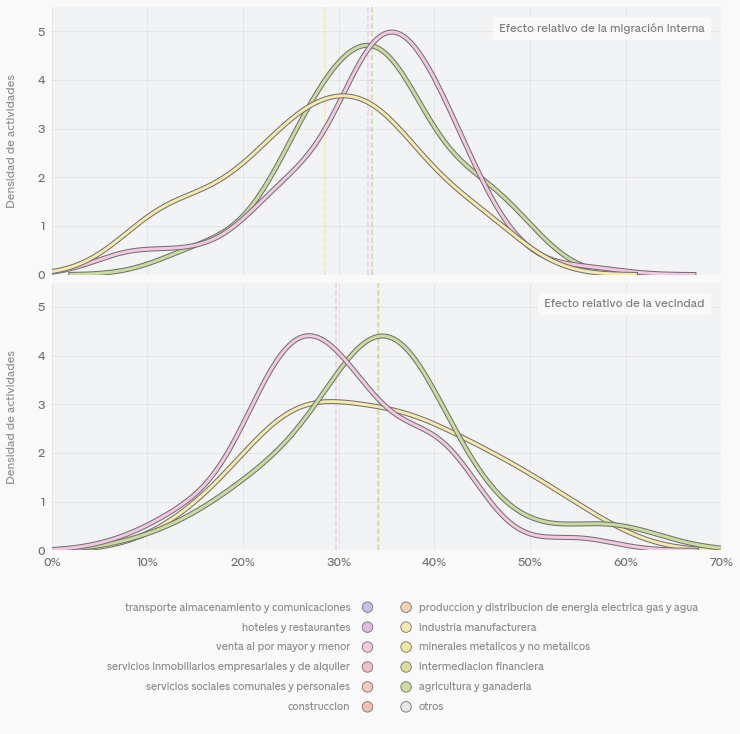

In [45]:
def plot_sectores(min_actividades):
    
    a = actividades_migracion[actividades_migracion.eventos >= 10]
    b = actividades_frontera[actividades_frontera.eventos >= 10]
    
    colores_categorias = {
        'venta al por mayor y menor': '#f5c6e2',
        'industria manufacturera': '#f7e8ab',
        'construccion': '#f5c0a9',
        'servicios inmobiliarios empresariales y de alquiler': '#f2bfc5',
        'transporte almacenamiento y comunicaciones': '#cabde7',
        'agricultura y ganaderia': '#c9dc9d',
        'hoteles y restaurantes': '#e4b9e6',
        'servicios sociales comunales y personales': '#fbc6bb',
        'produccion y distribucion de energia electrica gas y agua': '#f2d2b0',
        'intermediacion financiera': '#dcdc9d',
        'minerales metalicos y no metalicos': '#eee89d',
        'caza silvicultura y pesca': '#e7e7e7',
        'educacion': '#e7e7e7',
        'servicio de hogares privados que contratan servicio domestico': '#e7e7e7',
        'actividades atipicas': '#e7e7e7',
        'administracion publica defensa y seguridad social obligatoria': '#e7e7e7',
        'extraccion de petroleo crudo y gas natural': '#e7e7e7',
        'servicio de organizaciones y organos extraterritoriales': '#e7e7e7',
        'otros': '#e7e7e7',
    }
    
    categorias_orden = [
        'transporte almacenamiento y comunicaciones',
        'hoteles y restaurantes',
        'venta al por mayor y menor',
        'servicios inmobiliarios empresariales y de alquiler',
        'servicios sociales comunales y personales',
        'construccion',
        'produccion y distribucion de energia electrica gas y agua',
        'industria manufacturera',
        'minerales metalicos y no metalicos',
        'intermediacion financiera',
        'agricultura y ganaderia',
        'otros'
    ]
    
    
    f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    lincolor = '#6e6e6e'
    plt.subplots_adjust(hspace=.03)

    for ax, act, sec, xlabel in zip(axs, [a, b], [categorias_migracion, categorias_frontera], ['Efecto relativo de la migración interna', 'Efecto relativo de la vecindad']):
        for sector in sec[sec.actividades >= min_actividades].index:
            ax.axvline(sec.loc[sector, 'influencia_ponderada'], color=colores_categorias[sector], linewidth=1.5, zorder=1, linestyle='--')
            sns.kdeplot(act[act.categoria == sector].influencia_ponderada, color=colores_categorias[sector], lw=3, ax=ax, path_effects=[pe.Stroke(linewidth=5, foreground=lincolor), pe.Normal()], zorder=2)
        ax.grid(zorder=1)
        ax.tick_params(labelcolor=lincolor)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
        ax.set_ylabel('Densidad de actividades')
        ax.set_xlabel('')
        ax.set_ylim(0,5.5)
        ax.set_xlim(0,.7)        
        ax.annotate(xlabel, xy=(.975, .94), xycoords='axes fraction', alpha=.9, ha='right', va='top', fontsize=12, color=lincolor, bbox={'fc': '#f9f9f9', 'pad': 6, 'linewidth':0})
    
    for categorias_section, esquina, x, ha, xlim  in zip([categorias_orden[:6], categorias_orden[6:]], [.457, .46], [.4, 1.6], ['right', 'left'], [(0,3), (-2,2)]):
        cax = f.add_axes([esquina, -.12, .1, .18])
        cax.scatter(x=len(categorias_section) * [1], y=range(len(categorias_section)),  color=[colores_categorias[categoria] for categoria in categorias_section], s=110, linewidth=.8, edgecolor=lincolor)
        cax.set_xlim(xlim)
        cax.set_ylim(6.,-.5)
        for categoria, position in zip(categorias_section, range(len(categorias_section))):
            cax.annotate('\n'.join(textwrap.wrap(categoria, 100)), xy=(x, position), xycoords='data', ha=ha, va='center', fontsize=11, color=lincolor, alpha=.8)
        cax.set_axis_off()
        
plot_sectores(20)